
---
# SAiDL Spring 2025 Induction Assignment: Multi-Modality
---

## Table of Contents

### 1. Setting up the Environment

- [1.1 Importing the Necessary Packages](#11-importing-the-necessary-packages)
- [1.2 Downloading the Data](#12-downloading-the-data)
- [1.3 Detecting the GPU](#13-detecting-the-gpu)


### 2. Exploratory Data Analysis

- [2.1 Entities](#21-entities)
- [2.2 Edges](#22-edges)
- [2.3 Literals](#23-literals)
- [2.4 Triples](#24-triples)


### 3. Preparing the Data

- [3.1 Sampling a Subset](#31-sampling-a-subset)
- [3.2 Creating the Embeddings for Labeled Nodes](#32-creating-the-embeddings-for-labeled-nodes)
- [3.3 Generating the Embeddings](#33-generating-the-embeddings)


### 4. The Node Classification Process

- [4.1 Defining the Model](#41-defining-the-model)
    - [RGCNLayer Class](#rgcnlayer-class)
    - [RGCN Class](#rgcn-class)
- [4.2 Preparing the Data for Classification](#42-preparing-the-data-for-classification)
- [4.3 Helper function to Train the Model](#43-helper-function-to-train-the-model)
- [4.4 Helper function to Evaluate the Model](#44-helper-function-to-evaluate-the-model)
- [4.5 Putting it all Together](#45-putting-it-all-together)

# 1. Setting up the Environment
---

## 1.1 Importing the Necessary Packages

In [31]:
import os
import base64
import ast
import time
from io import BytesIO
from collections import Counter

import numpy as np
import matplotlib.pyplot as plt

from PIL import Image

import torch
import torch.nn as nn
import torch.nn.functional as F

from transformers import BertTokenizer, BertModel, ViTImageProcessor, ViTModel

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score

from tqdm import tqdm
from tqdm.notebook import tqdm  

import kgbench as kg

os.environ['CUDA_LAUNCH_BLOCKING'] = '1'
os.environ['TORCH_USE_CUDA_DSA'] = '1'

## 1.2 Downloading the Data

In [32]:
DATASET_NAME = "dmg777k"

print(f"Loading dataset: {DATASET_NAME}...")
data = kg.load(DATASET_NAME)
print("Dataset loaded successfully.")

Loading dataset: dmg777k...
loaded data dmg777k (48.75s).
Dataset loaded successfully.


## 1.3 Detecting the GPU

In [33]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


# 2. Exploratory Data Analysis
---

## 2.1 Entities

📊 ENTITIES:

In simple terms, entities are simply "things" or "objects" that the knowledge graph is built around. They are—the people, places, organizations, events, concepts, etc—representing the nodes in the knowledge graph, along with the literals that decribe them.

💡 Entities are broadly categorised into 2 categories:
    
🔹 Typed Entities (example):
  - http://bag.basisregistraties.overheid.nl/bag/id/geometry/4077922EE32E8BCD35FA39A8370F6AD4
  - https://data.labs.pdok.nl/rce/id/image/20371049
  - https://data.labs.pdok.nl/rce/id/image/20305978
  - http://bag.basisregistraties.overheid.nl/bag/id/geometry/21A014311775DC35A3DACD9ECF589615
  - http://bag.basisregistraties.overheid.nl/bag/id/geometry/44E6FBA30477AE512558B0D36A804869
✅ Number of typed entities: 129,367

🏷️ Untyped Entities (example):
  - https://data.labs.pdok.nl/rce/id/monument/8312
  - http://en.wikipedia.org/wiki/Zevenhuizen_(Utrecht)
  - http://sws.geonames.org/2743544/nearby.rdf
  - http://sws.geonames.org/2744827

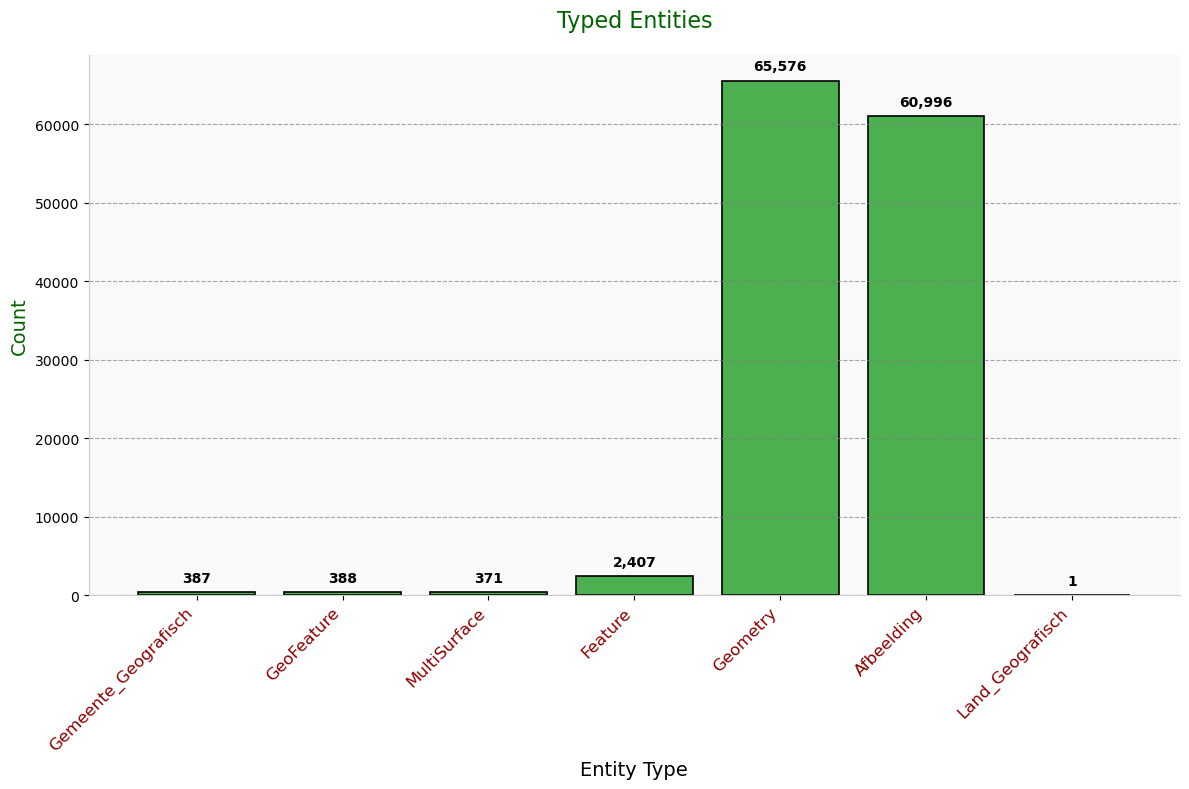

----------------------------------------------------------------------------------------------------------------------------------

📚 Total number of entities = (Typed + Untyped): 148127
📝 Total number of literals: 193143
🔢 Total number of nodes = (Entities + Literals): 341270


In [34]:
print("=" * 50)
print("📊 ENTITIES:")
print("=" * 50)

print(
    """
In simple terms, entities are simply "things" or "objects" that the knowledge graph is built around. They are—the people, places, organizations, events, concepts, etc—representing the nodes in the knowledge graph, along with the literals that decribe them.

💡 Entities are broadly categorised into 2 categories:
    """
)

type_relations = [r for r in data.i2r if "type" in r.lower()]

typed_entities = set()
for s, p, o in data.triples:
    if data.i2r[p] in type_relations:
        typed_entities.add(data.i2e[s]) 
        
typed_entities_str = set(e[0] for e in typed_entities)
all_entities = set(data.get_strings('iri')) | set(data.get_strings('blank_node'))
untyped_entities = all_entities - typed_entities_str

print("🔹 Typed Entities (example):")
for i, e in enumerate(typed_entities_str):
    print(f"  - {e}")
    if i >= 4: break
print(f"✅ Number of typed entities: {len(typed_entities_str):,}")

print("\n🏷️ Untyped Entities (example):")
for i, e in enumerate(untyped_entities):
    print(f"  - {e}")
    if i >= 4: break
print(f"⚠️ Number of untyped entities: {len(untyped_entities):,}")
print()
print("-" * 130)

entity_types = set()
for s, p, o in data.triples:
    if data.i2r[p] in type_relations:
        entity_types.add(str(data.i2e[o]))

entity_list = list(entity_types)
tuple_list = [ast.literal_eval(t) for t in entity_list]
entity_counts = {etype: 0 for etype in entity_types}

mapping = {
    'http://www.opengis.net/ont/geosparql#Geometry': 'Geometry',
    'https://data.labs.pdok.nl/rce/def/Afbeelding': 'Afbeelding',
    'https://data.pldn.nl/cbs/wijken-buurten/def/cbs#Land_Geografisch': 'Land_Geografisch',
    'http://www.opengis.net/ont/gml#MultiSurface': 'MultiSurface',
    'https://data.pldn.nl/cbs/wijken-buurten/def/cbs#Gemeente_Geografisch': 'Gemeente_Geografisch',
    'http://www.geonames.org/ontology#Feature': 'Feature',
    'http://www.opengis.net/ont/geosparql#Feature': 'GeoFeature',
}

entity_examples = {}

for s, p, o in data.triples:
    if data.i2r[p] in type_relations:
        entity_type = str(data.i2e[o])
        if entity_type in entity_counts:
            entity_counts[entity_type] += 1
            if entity_type not in entity_examples:
                entity_examples[entity_type] = data.i2e[s]

entity_types_list = [mapping.get(type, type) for type, _ in tuple_list]
counts = [entity_counts[str((type, 'iri'))] for type, _ in tuple_list]

print("\n📋 Typed entities can further be classified into 7 types:")
for i, (original_type, _) in enumerate(tuple_list):
    mapped_type = mapping.get(original_type, original_type)
    entity_type_str = str((original_type, 'iri'))
    example = entity_examples.get(entity_type_str, 'N/A')
    print()
    print(f"  {i+1}. {mapped_type}:")
    print(f"             Count: {counts[i]:,}")
    print(f"             Example: {example}")
    
print()
plt.figure(figsize=(12, 8))  
plt.bar(entity_types_list, counts, color='#4CAF50', edgecolor='black', linewidth=1.2)  
plt.title('Typed Entities', fontsize=16, pad=20, color='darkgreen')  
plt.ylabel('Count', fontsize=14, color='darkgreen') 
plt.xlabel('Entity Type', fontsize=14, color='black')  
plt.grid(axis='y', linestyle='--', alpha=0.7, color='gray') 
plt.xticks(rotation=45, fontsize=12, ha='right', color='darkred') 

for i, v in enumerate(counts):
    plt.text(i, v + max(counts)*0.02, f"{v:,}", ha='center', fontsize=10, fontweight='bold')

ax = plt.gca()
ax.set_facecolor('#f9f9f9')

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_color('#CCCCCC')
ax.spines['left'].set_color('#CCCCCC')

plt.annotate('', xy=(0, 0), xytext=(0, 0), xycoords='figure fraction', textcoords='figure fraction', arrowprops=dict(arrowstyle='-', color='gray', alpha=0.2))

plt.tight_layout()
plt.show()
print("-" * 130)

literals = sum(len(data.get_strings(dt)) for dt in data.datatypes() if dt not in ['iri', 'blank_node'])

print()
print(f"📚 Total number of entities = (Typed + Untyped): {len(data.get_strings('iri')) + len(data.get_strings('blank_node'))}")
print(f"📝 Total number of literals: {literals}")
print(f"🔢 Total number of nodes = (Entities + Literals): {data.num_entities}")

## 2.2 Edges

📊 EDGES:
  - Total Number of Edges: 777,124
  - Number of Unique Relation Types: 60


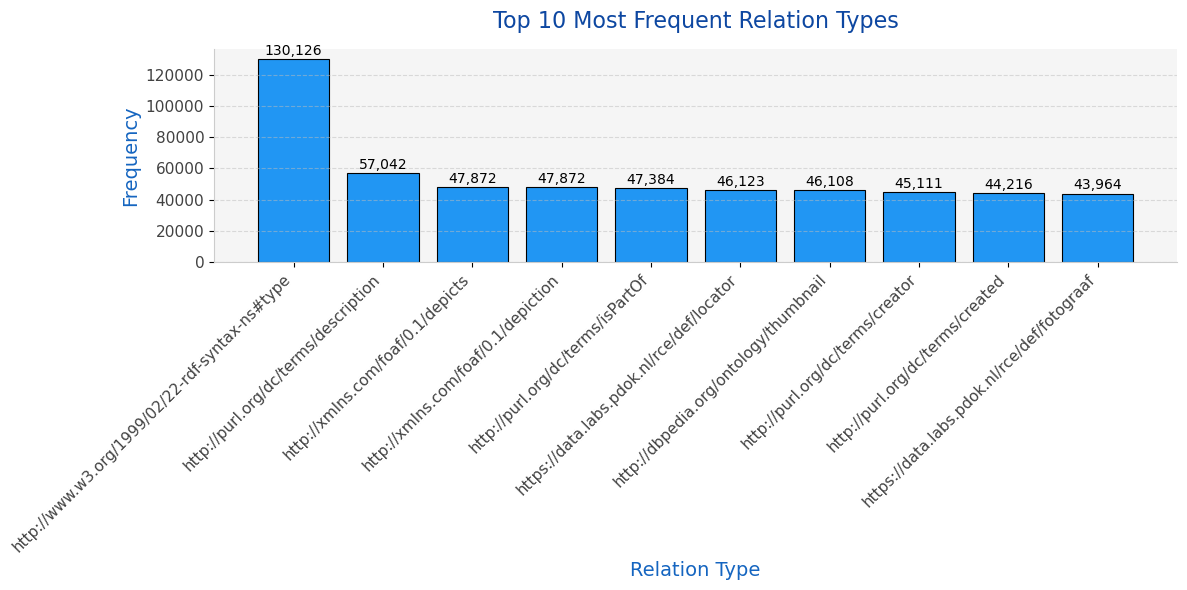

In [35]:
print("=" * 50)
print("📊 EDGES:")
print("=" * 50)
relation_counter = Counter(data.triples[:, 1])
total_edges = data.triples.shape[0]
print(f"  - Total Number of Edges: {total_edges:,}")
print(f"  - Number of Unique Relation Types: {data.num_relations}")

top_n = 10
most_common_relations = relation_counter.most_common(top_n)
relations, counts = zip(*most_common_relations)
relation_names = [data.i2r[rel] for rel in relations]

plt.figure(figsize=(12, 6))
plt.bar(relation_names, counts, color='#2196F3', edgecolor='black', linewidth=0.8)
plt.title(f'Top {top_n} Most Frequent Relation Types', fontsize=16, pad=15, color='#0D47A1')
plt.xlabel('Relation Type', fontsize=14, color='#1565C0')
plt.ylabel('Frequency', fontsize=14, color='#1565C0')
plt.xticks(rotation=45, ha='right', fontsize=11, color='#424242')
plt.yticks(fontsize=11, color='#424242')
plt.grid(axis='y', linestyle='--', alpha=0.5, color='#BDBDBD')

for i, v in enumerate(counts):
    plt.text(i, v + max(counts)*0.02, f"{v:,}", ha='center', fontsize=10)

ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_color('#CCCCCC')
ax.spines['left'].set_color('#CCCCCC')
ax.set_facecolor('#F5F5F5')

plt.tight_layout()
plt.show()

## 2.3 Literals

📊 LITERALS:

In a Knowledge Graph, literals are the actual data values that represent the information like strings, numbers, dates, or booleans — rather than entities or relationships.

💡 They're the leaf nodes that provide actual content rather than links to other nodes.

----------------------------------------------------------------------------------------------------------------------------------
📋 Following are the types of literals present in the KG -

🔹none:
     📦Modality - Language
     🔢Count - 27,886
  Example: 

🔹@es:
     📦Modality - Language
     🔢Count - 1
  Example: Maastricht

🔹@fy:
     📦Modality - Language
     🔢Count - 11
  Example: Aldeberkeap

🔹@nl:
     📦Modality - Language
     🔢Count - 397
  Example: 's-Gravenhage

🔹@nl-nl:
     📦Modality - Language
     🔢Count - 33,721
  Example: "'t Hof Alle Morgen Nieuwe Zorgen". Bakstenen woonhuis met pannen zadeldak. Tuittopgevels met vlecht...

🔹@pt:
     📦Modality - Language
     🔢Count - 1
  Example: Bladel

🔹@ru:
    

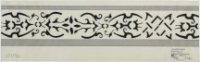


🔹http://www.opengis.net/ont/geosparql#wktLiteral:
     📦Modality - Spatial
     🔢Count - 20,837
  Example: MULTIPOLYGON (((3.3712379100119882 51.363607419127476, 3.3712319142327094 51.36358551924035, 3.37116...

🔹http://www.w3.org/2001/XMLSchema#anyURI:
     📦Modality - Uri
     🔢Count - 55,031
  Example: http://data.cultureelerfgoed.nl/semnet/037424cb-4ac6-45ec-8fa8-96278c1b9399

🔹http://www.w3.org/2001/XMLSchema#boolean:
     📦Modality - Boolean
     🔢Count - 2
  Example: false

🔹http://www.w3.org/2001/XMLSchema#gYear:
     📦Modality - Temporal
     🔢Count - 290
  Example: 1100

🔹http://www.w3.org/2001/XMLSchema#nonNegativeInteger:
     📦Modality - Numerical
     🔢Count - 8,396
  Example: 10000

🔹http://www.w3.org/2001/XMLSchema#positiveInteger:
     📦Modality - Numerical
     🔢Count - 495
  Example: 100

----------------------------------------------------------------------------------------------------------------------------------

📚 Total Literals: 193,143


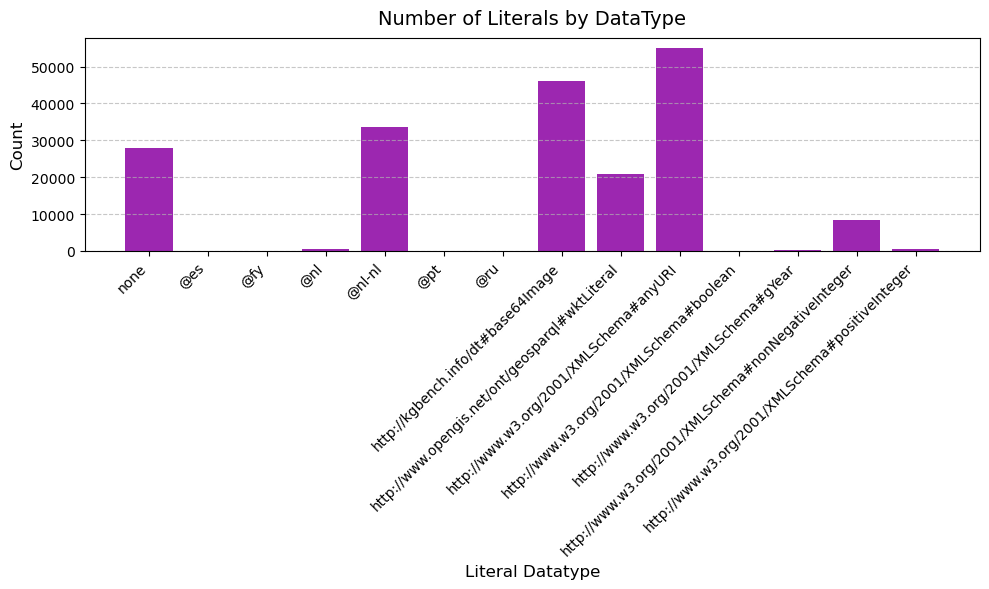

In [36]:
print("=" * 50)
print("📊 LITERALS:")
print("=" * 50)

datatypes = data.datatypes()
literal_datatypes = [dt for dt in datatypes if dt not in ['iri', 'blank_node']]

literal_counts = {}
literal_examples = {}

for dt in literal_datatypes:
    literals = data.get_strings(dt)
    literal_counts[dt] = len(literals)
    if literals: 
        literal_examples[dt] = literals[0]

print('''
In a Knowledge Graph, literals are the actual data values that represent the information like strings, numbers, dates, or booleans — rather than entities or relationships.

💡 They're the leaf nodes that provide actual content rather than links to other nodes.
'''
)
print("-" * 130)

print("📋 Following are the types of literals present in the KG -")
print()

def infer_modality_from_datatype(dt):
    dt = dt.lower()
    if dt in ['none'] or dt.startswith('@'):
        return 'Language'
    elif 'base64image' in dt:
        return 'Visual'
    elif 'wktliteral' in dt:
        return 'Spatial'
    elif 'anyuri' in dt:
        return 'Uri'
    elif 'boolean' in dt:
        return 'Boolean'
    elif 'gyear' in dt or 'date' in dt or 'time' in dt:
        return 'Temporal'
    elif 'nonnegativeinteger' in dt or 'positiveinteger' in dt or 'integer' in dt or 'float' in dt or 'decimal' in dt:
        return 'Numerical'
    else:
        return 'Unknown'

datatypes = data.datatypes()
literal_datatypes = [dt for dt in datatypes if dt not in ['iri', 'blank_node']]

total_literals = 0
for dt in literal_datatypes:
    strings = data.get_strings(dt)
    count = len(strings)
    modality = infer_modality_from_datatype(dt)
    total_literals += count
    sample_literals = strings[:1]  

    print(f"🔹{dt}:")
    print(f"     📦Modality - {modality}")
    print(f"     🔢Count - {count:,}")
    for i, lit in enumerate(sample_literals):
        if modality=="Visual":
            b64 = lit.replace('_', '/').replace('-', '+')
            b64 += '=' * (-len(b64) % 4)
            
            img_data = base64.b64decode(b64)
            img = Image.open(BytesIO(img_data))
            
            print(f"Example: ", sep="")
            display(img)
        else:
            display_str = lit[:100] + '...' if len(lit) > 100 else lit
            print(f"  Example: {display_str}")
    print()

print("-" * 130)
print(f"\n📚 Total Literals: {total_literals:,}")

plt.figure(figsize=(10, 6))
plt.bar(literal_datatypes, literal_counts.values(), color='#9C27B0')
plt.title('Number of Literals by DataType', fontsize=14, pad=10)
plt.xlabel('Literal Datatype', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

## 2.4 Triples

In [37]:
print("=" * 60)
print("📊 (d) TRIPLES: ")
print("=" * 60)

print('''
💡 Triple are the main structures that define the graph. They are defined using numpy arrays, denoting the edges in a graph via a list of 3 elements denoting the subject, predicate and the object.
''')
print("   • 🧑‍💼 Subject and 🎯 Object are represented as entity indices.")
print("   • 🔗 Relation is the relation/predicate index connecting them.")
print("   • This structure enables GNNs to treat entities as nodes and relations as edges.")
print()

print(f"🔢 Triples Shape: {data.triples.shape}")
print(f"🔹(rows ⇒ edges, columns ⇒ [subject, relation/predicate, object])")
print()
print("-" * 130)
print(f"📌 Example Triple (raw indices): {data.triples[0]}")
print()

print(f"🧑‍💼 Subject (s): {data.i2e[data.triples[0,0]]}")
print()
print(f"🔗 Relation (r): {data.i2r[data.triples[0,1]]}")
print()
print(f"🎯 Object (o): {data.i2e[data.triples[0,2]][:50]}...")

📊 (d) TRIPLES: 

💡 Triple are the main structures that define the graph. They are defined using numpy arrays, denoting the edges in a graph via a list of 3 elements denoting the subject, predicate and the object.

   • 🧑‍💼 Subject and 🎯 Object are represented as entity indices.
   • 🔗 Relation is the relation/predicate index connecting them.
   • This structure enables GNNs to treat entities as nodes and relations as edges.

🔢 Triples Shape: (777124, 3)
🔹(rows ⇒ edges, columns ⇒ [subject, relation/predicate, object])

----------------------------------------------------------------------------------------------------------------------------------
📌 Example Triple (raw indices): [130685     28  54795]

🧑‍💼 Subject (s): ('http://bag.basisregistraties.overheid.nl/bag/id/geometry/0003549B7CE875B77925FFA6CC2C2861', 'iri')

🔗 Relation (r): http://www.opengis.net/ont/geosparql#asWKT

🎯 Object (o): ('POLYGON ((4.667227191836703 51.81920171648348, 4.667236120685068 51.819203883584755, 4.6672263

# 3. Preparing the Data
---

## 3.1 Sampling a Subset

In [38]:
def create_kg_subset(data, max_hops=2, sample_ratio=0.01):
    """
    This function creates a manageable subset of a knowledge graph by:
    1. Sampling a percentage of labeled entities based on the sample_ratio parameter
    2. Expanding the neighborhood around these entities up to max_hops distance
    3. Including all triples where either subject or object is in the neighborhood
    4. Returning both the subset of triples and the originally sampled entities

    The SubsetKG class then wraps this subset with the original mappings and datatypes while filtering the training data to only include the sampled entities, making it easier to work with a smaller portion of a large knowledge graph.
    """
    if not hasattr(data, 'training') or data.training.size == 0:
        raise ValueError("No training data available")

    labeled_entities = np.unique(data.training[:, 0])
    sample_size = max(1, int(len(labeled_entities) * sample_ratio))
    sampled_entities = np.random.choice(labeled_entities, sample_size, False)
    
    print(f"🔍 Sampled {len(sampled_entities)}/{len(labeled_entities)} labeled entities.\n")
    
    neighborhood = set(sampled_entities)
    for _ in range(max_hops):
        new_neighbors = set()
        for s, p, o in data.triples:
            if s in neighborhood or o in neighborhood:
                new_neighbors.update({s, o})
        neighborhood.update(new_neighbors)
        print(f"🔹Hop {_+1}: {len(neighborhood)} entities.")
    
    subset_triples = [t for t in data.triples 
                     if t[0] in neighborhood or t[2] in neighborhood]
    
    print()
    print(f"📏Final subset: {len(subset_triples)} triples.")
    return np.array(subset_triples), sampled_entities

class SubsetKG:
    """
    A class to wrap the subset of the knowledge graph.
    """
    def __init__(self, original_data, subset_triples, sampled_entities):
        self.i2r = original_data.i2r
        self.i2e = original_data.i2e
        self.triples = subset_triples
        self.sampled_entities = sampled_entities
        
        self.training = original_data.training[
            np.isin(original_data.training[:,0], self.sampled_entities)
        ]
        print(f"📦 Wrapping the data...")
    
    def datatypes(self):
        return {dtype for _, dtype in self.i2e if dtype not in ('iri', 'blank_node')}

## 3.2 Creating the Embeddings for Labeled Nodes

In [39]:
def create_labeled_embeddings(data):
    """
    This function creates embeddings for labeled entities in a knowledge graph.
    It uses BERT for text embeddings and ViT for image embeddings. The function
    processes entity URIs and their associated literals, combining them to create
    a final embedding for each entity. It handles both textual and image data,
    limiting to 3 literals per entity for efficiency.
    """
    if not hasattr(data, 'training') or data.training.size == 0:
        raise ValueError("No training data available")
    
    bert_tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
    bert_model = BertModel.from_pretrained('bert-base-uncased').to(device)
    
    vit_extractor = ViTImageProcessor.from_pretrained('google/vit-base-patch16-224-in21k')
    vit_model = ViTModel.from_pretrained('google/vit-base-patch16-224-in21k').to(device)

    def quick_bert(text):
        inputs = bert_tokenizer(
            text[:128], 
            return_tensors='pt', 
            padding=True, 
            truncation=True, 
            max_length=128
        ).to(device)
        with torch.no_grad():
            outputs = bert_model(**inputs)
        return outputs.last_hidden_state.mean(dim=1).squeeze().cpu().numpy()

    def fast_vit(img_str):
        try:
            img = Image.open(BytesIO(base64.b64decode(img_str))).convert('RGB')
            inputs = vit_extractor(images=img, return_tensors="pt").pixel_values.to(device)
            with torch.no_grad():
                outputs = vit_model(inputs)
            return outputs.last_hidden_state.mean(dim=1).squeeze().cpu().numpy()
        except:
            return None

    embeddings = {}
    nodes_to_process = data.training[:, 0]
    
    with tqdm(nodes_to_process, desc="Creating embeddings") as bar:
        for node in bar:
            try:
                uri = data.i2e[node][0][:50]
            except:
                uri = str(node)
            
            uri_embed = quick_bert(uri)
            
            literal_embeds = []
            for s, p, o in data.triples:
                if s != node:
                    continue
                if data.i2e[o][1] in data.datatypes():
                    value, dtype = data.i2e[o]
                    
                    if 'http://kgbench.info/dt#base64Image' in dtype:
                        img_embed = fast_vit(value)
                        if img_embed is not None:
                            literal_embeds.append(img_embed)
                    else:
                        literal_embeds.append(quick_bert(str(value)[:200]))
                    
                    if len(literal_embeds) >= 3:
                        break
            
            if literal_embeds:
                final_embed = np.mean([uri_embed] + literal_embeds, axis=0)
            else:
                final_embed = uri_embed
            
            embeddings[node] = final_embed.astype(np.float32)
    
    return embeddings

## 3.3 Generating the Embeddings 

In [40]:
subset_triples, sampled_entities = create_kg_subset(data, sample_ratio=0.2)
subset_kg = SubsetKG(data, subset_triples, sampled_entities)
labeled_embeddings = create_labeled_embeddings(subset_kg)

🔍 Sampled 1078/5394 labeled entities.

🔹Hop 1: 16172 entities.
🔹Hop 2: 47369 entities.

📏Final subset: 621715 triples.
📦 Wrapping the data...


Creating embeddings:   0%|          | 0/1078 [00:00<?, ?it/s]

# 4. The Node Classification Process
---

## 4.1 Defining the Model

In [41]:
class RGCNLayer(nn.Module):
    """
    Relation-specific graph convolution layer with optional basis decomposition for parameter efficiency.
    """
    def __init__(self, in_dim, out_dim, num_relations, num_bases=None):
        super(RGCNLayer, self).__init__()
        self.in_dim = in_dim
        self.out_dim = out_dim
        self.num_relations = num_relations
        self.num_bases = num_bases if num_bases else num_relations
        
        if self.num_bases < self.num_relations:
            self.weights = nn.Parameter(torch.Tensor(self.num_bases, self.in_dim, self.out_dim))
            self.coefs = nn.Parameter(torch.Tensor(self.num_relations, self.num_bases))
            nn.init.xavier_uniform_(self.weights)
            nn.init.xavier_uniform_(self.coefs)
        else:
            self.weights = nn.Parameter(torch.Tensor(self.num_relations, self.in_dim, self.out_dim))
            nn.init.xavier_uniform_(self.weights)
            
        self.bias = nn.Parameter(torch.Tensor(self.out_dim))
        nn.init.zeros_(self.bias)
            
    def forward(self, x, edge_index, edge_type):
        device = x.device
        
        if self.num_bases < self.num_relations:
            weight = torch.einsum('rb,bio->rio', self.coefs, self.weights)
        else:
            weight = self.weights
            
        out = torch.zeros(x.size(0), self.out_dim, device=device)
        
        for rel in range(self.num_relations):
            mask = (edge_type == rel)
            if mask.sum() > 0:
                src, dst = edge_index[0, mask], edge_index[1, mask]
                
                transformed = torch.matmul(x[src], weight[rel])
                
                index = dst.view(-1, 1).expand(-1, self.out_dim)
                out.scatter_add_(0, index, transformed)
        
        return out + self.bias


class RGCN(nn.Module):
    """
    Two-layer RGCN model with entity embeddings and classification head.
    """
    def __init__(self, num_entities, num_relations, num_classes, embedding_dim, hidden_dim=128, num_bases=30, dropout=0.2):
        super(RGCN, self).__init__()
        
        self.embedding_dim = embedding_dim
        self.entity_embeddings = nn.Parameter(torch.Tensor(num_entities, embedding_dim))
        nn.init.xavier_uniform_(self.entity_embeddings)
        
        self.conv1 = RGCNLayer(embedding_dim, hidden_dim, num_relations, num_bases)
        self.conv2 = RGCNLayer(hidden_dim, hidden_dim, num_relations, num_bases)
        self.classifier = nn.Linear(hidden_dim, num_classes)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, edge_index, edge_type, pretrained_embeddings=None):
        x = self.entity_embeddings.clone()
        if pretrained_embeddings is not None:
            for entity_id, embedding in pretrained_embeddings.items():
                if entity_id < x.size(0):
                    x[entity_id] = torch.tensor(embedding, dtype=torch.float32, device=x.device)
        
        x = F.relu(self.conv1(x, edge_index, edge_type))
        x = self.dropout(x)
        x = F.relu(self.conv2(x, edge_index, edge_type))
        x = self.dropout(x)
        x = self.classifier(x)
        
        return x, F.log_softmax(x, dim=1)

## 4.2 Preparing the Data for Classification

In [42]:
def prepare_data(kg_data, labeled_embeddings):
    """
    Prepares the data to perform classification.
    """
    print("🔄 Preparing data for RGCN...")
    entities = set()
    relations = set()
    
    with tqdm(kg_data.triples, desc="Processing triples") as bar:
        for s, p, o in bar:
            entities.add(s)
            relations.add(p)
            entities.add(o)
    
    entity_map = {ent: i for i, ent in enumerate(entities)}
    relation_map = {rel: i for i, rel in enumerate(relations)}
    
    edge_index = []
    edge_type = []
    
    with tqdm(kg_data.triples, desc="Creating edge indices") as bar:
        for s, p, o in bar:
            edge_index.append([entity_map[s], entity_map[o]])
            edge_type.append(relation_map[p])
    
    edge_index = torch.tensor(edge_index, dtype=torch.long).t()
    edge_type = torch.tensor(edge_type, dtype=torch.long)
    
    mapped_embeddings = {}
    with tqdm(labeled_embeddings.items(), desc="Mapping embeddings") as bar:
        for entity_id, embedding in bar:
            if entity_id in entity_map:
                mapped_embeddings[entity_map[entity_id]] = embedding
    
    labels = {}
    with tqdm(kg_data.training, desc="Processing labels") as bar:
        for entity_id, label in bar:
            if entity_id in entity_map:
                labels[entity_map[entity_id]] = int(label)
    
    embedding_dim = next(iter(mapped_embeddings.values())).shape[0]
    
    return (edge_index, edge_type, entity_map, relation_map, len(entities), len(relations), mapped_embeddings, labels, embedding_dim)

## 4.3 Helper function to Train the Model

In [46]:
def train_model(model, edge_index, edge_type, embeddings, labels, num_epochs=100, lr=0.01, device='cuda'):
    """
    Trains the model.
    """
    model = model.to(device)
    edge_index = edge_index.to(device)
    edge_type = edge_type.to(device)
    
    label_indices = []
    label_values = []
    for entity_id, label in labels.items():
        label_indices.append(entity_id)
        label_values.append(label)
    
    label_indices = torch.tensor(label_indices, dtype=torch.long).to(device)
    label_values = torch.tensor(label_values, dtype=torch.long).to(device)
    
    train_idx, val_idx = train_test_split(np.arange(len(label_indices)), test_size=0.2, random_state=42, stratify=label_values.cpu().numpy())
    
    train_idx = torch.tensor(train_idx, dtype=torch.long).to(device)
    val_idx = torch.tensor(val_idx, dtype=torch.long).to(device)
    
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=5e-4)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', patience=10)
    
    best_val_f1 = 0
    best_model = None
    patience = 0
    
    epochs_bar = tqdm(range(num_epochs), desc="Training epochs")
    
    for epoch in epochs_bar:
        model.train()
        start_time = time.time()
        
        optimizer.zero_grad()
        
        forward_start = time.time()
        _, logits = model(edge_index, edge_type, embeddings)
        forward_time = time.time() - forward_start
        
        loss = F.nll_loss(logits[label_indices[train_idx]], label_values[train_idx])
        
        backward_start = time.time()
        loss.backward()
        backward_time = time.time() - backward_start
        
        optimizer.step()
        
        model.eval()
        with torch.no_grad():
            _, val_logits = model(edge_index, edge_type, embeddings)
            val_pred = val_logits[label_indices[val_idx]].argmax(dim=1)
            val_f1 = f1_score(label_values[val_idx].cpu(), val_pred.cpu(), average='weighted')
            val_acc = accuracy_score(label_values[val_idx].cpu(), val_pred.cpu())
            
        scheduler.step(val_f1)
        
        if val_f1 > best_val_f1:
            best_val_f1 = val_f1
            best_model = model.state_dict().copy()
            patience = 0
        else:
            patience += 1
        
        epoch_time = time.time() - start_time
        
        epochs_bar.set_postfix({
            'loss': f"{loss.item():.4f}",
            'val_f1': f"{val_f1:.4f}",
            'val_acc': f"{val_acc:.4f}",
            'time': f"{epoch_time:.2f}s",
            'forward': f"{forward_time:.2f}s",
            'backward': f"{backward_time:.2f}s"
        })
        
        if patience >= 20:
            epochs_bar.write(f"⚠️ Early stopping at epoch {epoch}")
            break
    
    model.load_state_dict(best_model)
    return model

## 4.4 Helper function to Evaluate the Model

In [47]:
def evaluate_model(model, edge_index, edge_type, embeddings, labels, device='cuda'):
    """
    Evaluates the model.
    """
    model.eval()
    edge_index = edge_index.to(device)
    edge_type = edge_type.to(device)
    
    label_indices = []
    label_values = []
    for entity_id, label in labels.items():
        label_indices.append(entity_id)
        label_values.append(label)
    
    label_indices = torch.tensor(label_indices, dtype=torch.long).to(device)
    label_values = torch.tensor(label_values, dtype=torch.long).to(device)
    
    start_time = time.time()
    with torch.no_grad():
        _, logits = model(edge_index, edge_type, embeddings)
        pred = logits[label_indices].argmax(dim=1)
        acc = accuracy_score(label_values.cpu(), pred.cpu())
        f1 = f1_score(label_values.cpu(), pred.cpu(), average='weighted')
    
    eval_time = time.time() - start_time
    print(f"⏱️ Evaluation time: {eval_time:.2f} seconds")
    print(f"🔶 Test accuracy: {acc:.4f}")
    print(f"🔶 Test F1 score: {f1:.4f}")
    
    return pred.cpu().numpy()

## 4.5 Putting it all Together

In [50]:
print("\n" + "="*50)
print("🚀 Starting RGCN node classification...")
print("="*50)
(edge_index, edge_type, entity_map, relation_map, num_entities, num_relations, mapped_embeddings, labels, embedding_dim) = prepare_data(subset_kg, labeled_embeddings)

num_classes = max(labels.values()) + 1
print(f"📊 Subset Statistics:")
print(f" -    Entities: {num_entities:,}")
print(f" -    Relations: {num_relations:,}")
print(f" -    Classes: {num_classes}")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"\n💻 Using device: {device}")
num_bases = min(30, num_relations)

hidden_dim = 64 if num_entities > 100000 else 128 
print(f"\n🔍 Using hidden dimension: {hidden_dim}")

print("\n🔧 Building RGCN model...")
model = RGCN(
    num_entities, 
    num_relations, 
    num_classes, 
    embedding_dim, 
    hidden_dim=hidden_dim, 
    num_bases=num_bases, 
    dropout=0.2
)

model_size = sum(p.numel() for p in model.parameters())
print(f"📏 Model parameters: {model_size:,}")

trained_model = train_model(
    model, 
    edge_index, 
    edge_type, 
    mapped_embeddings, 
    labels, 
    num_epochs=50, 
    lr=0.01, 
    device=device
)

print("📈 Evaluating model...")
predictions = evaluate_model(trained_model, edge_index, edge_type, mapped_embeddings, labels, device=device)

entity_map_reverse = {v: k for k, v in entity_map.items()}
entity_predictions = {}

label_indices = []
for entity_id in labels.keys():
    label_indices.append(entity_id)

print("\n🔄 Mapping predictions to original entity IDs...")
with tqdm(enumerate(label_indices), total=len(label_indices)) as bar:
    for i, idx in bar:
        original_id = entity_map_reverse[idx]
        entity_predictions[original_id] = int(predictions[i])

print(f"\n✅ Made predictions for {len(entity_predictions):,} entities\n")
print("="*50)
print("🎉 Node classification complete!")
print("="*50 + "\n")


🚀 Starting RGCN node classification...
🔄 Preparing data for RGCN...


Processing triples:   0%|          | 0/621715 [00:00<?, ?it/s]

Creating edge indices:   0%|          | 0/621715 [00:00<?, ?it/s]

Mapping embeddings:   0%|          | 0/1078 [00:00<?, ?it/s]

Processing labels:   0%|          | 0/1078 [00:00<?, ?it/s]

📊 Subset Statistics:
 -    Entities: 209,879
 -    Relations: 58
 -    Classes: 5

💻 Using device: cuda

🔍 Using hidden dimension: 64

🔧 Building RGCN model...
📏 Model parameters: 162,788,445


Training epochs:   0%|          | 0/50 [00:00<?, ?it/s]

⚠️ Early stopping at epoch 40
📈 Evaluating model...
⏱️ Evaluation time: 0.11 seconds
🔶 Test accuracy: 0.5547
🔶 Test F1 score: 0.4636

🔄 Mapping predictions to original entity IDs...


  0%|          | 0/1078 [00:00<?, ?it/s]


✅ Made predictions for 1,078 entities

🎉 Node classification complete!

